Installing Library

In [ ]:
!pip install nltk

In [ ]:
!pip install -U spacy
!pip install wordcloud
!pip install yellowbrick
!pip install sklearn
!pip install xgboost
!pip install --upgrade click
!python -m spacy download en_core_web_sm


In [ ]:
nltk.download('omw-1.4')

Import Library

In [1]:
import pickle
import statistics

import pandas as pd

import nltk
import unidecode as unidecode
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder

import re
import string

import spacy
from spacy import displacy

from xgboost import XGBClassifier

Preprocessing Text

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('alldata_1_for_kaggle.csv', encoding="latin-1")
df = df.rename(columns={'Unnamed: 0': 'index', '0': 'Type', 'a': 'Description'})

In [4]:
sw = stopwords.words('english')

In [5]:
def clean_text(text):
    text = text.lower()
    # remove
    text = re.sub('\[.*?\]', '', text)
    # remove links
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # remove tags
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove breaklines
    text = re.sub('\n', '', text)
    # remove numbers
    text = re.sub('\w*\d\w*', '', text)

    # Changing Text that's not in ascii into ascii (Ex: kožušček -> kozuscek; 30 \U0001d5c4\U0001d5c6/\U0001d5c1 -> 30 km/h)
    text = unidecode.unidecode(text)

    # transform text into token
    text_token = nltk.word_tokenize(text)

    # remove stopwords
    words = [w for w in text_token if w not in sw]

    return ' '.join(words)

df['Description'] = df['Description'].apply(clean_text)

Lemmatizer

In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_sentence(text):
    # transform text into token
    text_token = nltk.word_tokenize(text)
    lemmatized_sentence = []
    for word in text_token:
        lemmatized_sentence.append(lemmatizer.lemmatize(word))
    return " ".join(lemmatized_sentence)

df['Description'] = df['Description'].apply(lemmatize_sentence)

Word Embedding

In [10]:
vector = TfidfVectorizer(max_df=0.8,min_df=0.2)
docs = vector.fit_transform(df['Description'].tolist())
#features = vector.get_feature_names()

Declaring XGBoost Model and SKCV

In [11]:
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

mxgb = XGBClassifier(objective='multi:softmax',num_class=3)
classification_report_XGBoost = []

SKCV = model_selection.StratifiedKFold(n_splits=10)

Training Model

In [12]:
for train_index,test_index in SKCV.split(docs,df['Type']):
    X_train, X_test = docs[train_index], docs[test_index]
    y_train,y_test = df['Type'][train_index], df['Type'][test_index]

    mxgb.fit(X_train,y_train)

    prediction = mxgb.predict(X_test)

    matrix = classification_report(y_test,prediction,output_dict=True)
    # print(matrix)
    classification_report_XGBoost.append(matrix)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Extract precision, recall, and F1-score values for each class from each fold's classification report
precision = []
recall = []
f1_score = []
for report in classification_report_XGBoost:
    precision.append(report['macro avg']['precision'])
    recall.append(report['macro avg']['recall'])
    f1_score.append(report['macro avg']['f1-score'])

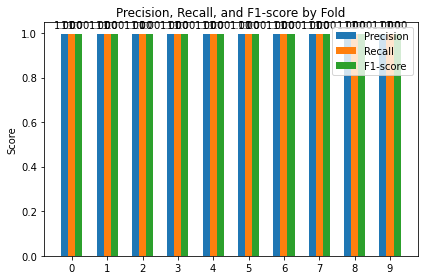

In [14]:

# Plot precision, recall, and F1-score for each fold
x = np.arange(len(classification_report_XGBoost))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1-score by Fold')
ax.set_xticks(x)
ax.legend()

# Add values above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

In [15]:
for report in classification_report_XGBoost:
    print(report)

{'0': {'precision': 0.9961240310077519, 'recall': 0.9961240310077519, 'f1-score': 0.9961240310077519, 'support': 258}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 218}, '2': {'precision': 0.99644128113879, 'recall': 0.99644128113879, 'f1-score': 0.99644128113879, 'support': 281}, 'accuracy': 0.9973579920739762, 'macro avg': {'precision': 0.997521770715514, 'recall': 0.997521770715514, 'f1-score': 0.997521770715514, 'support': 757}, 'weighted avg': {'precision': 0.9973579920739762, 'recall': 0.9973579920739762, 'f1-score': 0.9973579920739762, 'support': 757}}
{'0': {'precision': 0.9923076923076923, 'recall': 1.0, 'f1-score': 0.9961389961389961, 'support': 258}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 218}, '2': {'precision': 1.0, 'recall': 0.9928825622775801, 'f1-score': 0.9964285714285714, 'support': 281}, 'accuracy': 0.9973579920739762, 'macro avg': {'precision': 0.9974358974358974, 'recall': 0.9976275207591933, 'f1-score': 0.997522522

In [ ]:
with open('modelXGBoost','wb') as f:
    pickle.dump(mxgb,f)